In [141]:
!pip install texttable
!pip install texttable rasterio

import ee
import geemap
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.exposure import match_histograms
import time
import texttable as tt
import rasterio
from rasterio.plot import reshape_as_raster

In [142]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
# Path configuration
# Path configuration for Google Drive

#These are the images used, B2 , B3, B4 from the sentinal2 bandwise images and pla.tif is the planetscope image

out_dir = '/content/drive/My Drive/rec-2nd'
filename_b2 = os.path.join(out_dir, 'B2.tif')
filename_b3 = os.path.join(out_dir, 'B3.tif')
filename_b4 = os.path.join(out_dir, 'B4.tif')
filename_pan = os.path.join(out_dir, 'pla.tif')


# Multiespectral bands
r_img_B2 = rasterio.open(filename_b2)
r_img_B3 = rasterio.open(filename_b3)
r_img_B4 = rasterio.open(filename_b4)
img_B2 = r_img_B2.read(1)
img_B3 = r_img_B3.read(1)
img_B4 = r_img_B4.read(1)

# Panchromatic band
r_img_pan = rasterio.open(filename_pan)
img_pan = r_img_pan.read(1)

# Images metadata
print('Sentinel-2 -> band 2 shape:',img_B2.shape, '| Range (min, max): (', np.amin(img_B2), ',', np.amax(img_B2), ')')
print('Sentinel-2 -> band 3 shape:',img_B3.shape, '| Range (min, max): (', np.amin(img_B3), ',', np.amax(img_B3), ')')
print('Sentinel-2 -> band 4 shape:',img_B4.shape, '| Range (min, max): (', np.amin(img_B4), ',', np.amax(img_B4), ')')
print('PlanetScope -> panchromatic shape:',img_pan.shape, '| Range (min, max): (', np.amin(img_pan), ',', np.amax(img_pan), ')')

# Concatenate the bands of the multiespectral image into a single numpy array
R = np.expand_dims(img_B4, axis=2)
G = np.expand_dims(img_B3, axis=2)
B = np.expand_dims(img_B2, axis=2)

img_xs = np.concatenate((R,G), axis=2)
img_xs = np.concatenate((img_xs,B), axis=2)
print('Multiespectral image shape:', img_xs.shape)

Sentinel-2 -> band 2 shape: (474, 983) | Range (min, max): ( 1049 , 4772 )
Sentinel-2 -> band 3 shape: (474, 983) | Range (min, max): ( 1165 , 5456 )
Sentinel-2 -> band 4 shape: (474, 983) | Range (min, max): ( 1116 , 5960 )
PlanetScope -> panchromatic shape: (474, 983) | Range (min, max): ( 0 , 2312 )
Multiespectral image shape: (474, 983, 3)


In [144]:
#EXTRA EXTRA EXTRA - for creating synthetic panchromatic band

import os
import numpy as np
import rasterio

# Assuming you have a directory path and the PlanetScope filename
out_dir = '/content/drive/My Drive/rec-2nd'
filename_planetscope = os.path.join(out_dir, 'pla.tif')  # Correct filename

# Open the PlanetScope multispectral image
with rasterio.open(filename_planetscope) as ps_img:
    # Read only the RGB bands (assuming they are bands 1, 2, and 3)
    blue = ps_img.read(1)
    green = ps_img.read(2)
    red = ps_img.read(3)

    # Create a synthetic panchromatic band by averaging the RGB bands
    img_pan = (blue.astype(float) + green.astype(float) + red.astype(float)) / 3
    # pan_synthetic is now a single-band array representing the synthetic panchromatic band

    out_meta = ps_img.meta
    out_meta.update({"count": 1})

# Now you can proceed with the pansharpening process, using pan_synthetic as the high-resolution band


In [145]:
#for displaying multispectral planetscope image:

with rasterio.open(filename_planetscope) as ps_img:
    # Read the RGB bands (assuming they are bands 1, 2, and 3)
    blue = ps_img.read(1)
    green = ps_img.read(2)
    red = ps_img.read(3)

    # Normalize the RGB bands
    blue_normalized = (((blue - blue.min()) / (blue.max() - blue.min())) * 255).astype(int)
    green_normalized = (((green - green.min()) / (green.max() - green.min())) * 255).astype(int)
    red_normalized = (((red - red.min()) / (red.max() - red.min())) * 255).astype(int)

    # Stack the RGB bands into a single image
    planetscope_rgb = np.dstack((red_normalized, green_normalized, blue_normalized))

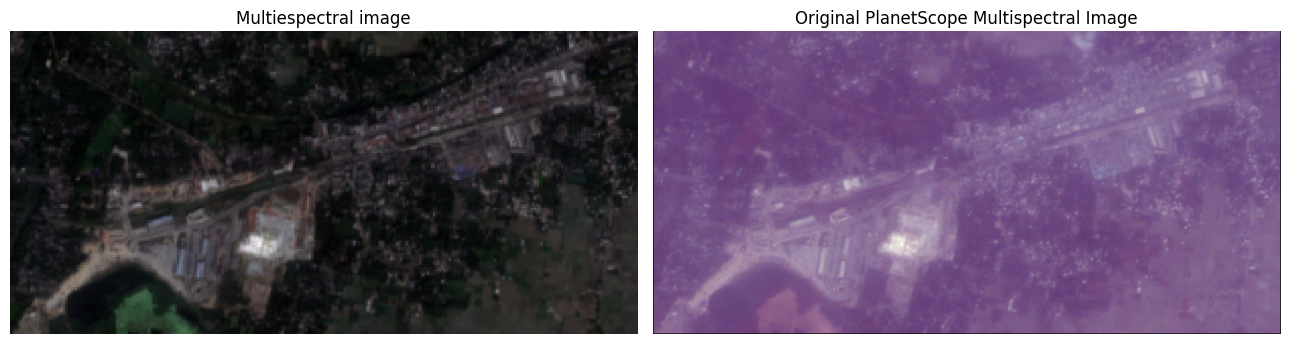

In [146]:
# Multiespectral image normalization
R = (((R-np.amin(R))/(np.amax(R)-np.amin(R)))*255).astype(int)
G = (((G-np.amin(G))/(np.amax(G)-np.amin(G)))*255).astype(int)
B = (((B-np.amin(B))/(np.amax(B)-np.amin(B)))*255).astype(int)
xs = np.concatenate((R,G), axis=2)
xs = np.concatenate((xs,B), axis=2)

# Panchromatic image normalization
pan = (((img_pan-np.amin(img_pan))/(np.amax(img_pan)-np.amin(img_pan)))*255).astype(int)

# Container creation, to fit the plots
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 10))

# Add the multiespectral image to the container
ax0.imshow(xs)
ax0.set_title("Multiespectral image")
ax0.axis('off')

# Add the panchromatic image to the container
# ax1.imshow(pan, 'gray')
# ax1.set_title("panchromatic planetscope image")
# ax1.axis('off')

ax1.imshow(planetscope_rgb)
ax1.set_title("Original PlanetScope Multispectral Image")
ax1.axis('off')

plt.tight_layout()

In [147]:
output_path = '/content/drive/My Drive/RCAN/panchromatic_planet_from_panshar.tif'
with rasterio.open(output_path, 'w', **out_meta) as dst:
    dst.write(pan, 1)  # Write the pan band

print(f"Output saved to {output_path}")

Output saved to /content/drive/My Drive/RCAN/panchromatic_planet_from_panshar.tif


In [148]:
#degradation filter


# Base filter used to degradate the images
base_filter = 1/256 * np.array([[1, 4, 6, 4 ,1],
[4, 16, 24, 16, 4],
[6, 24, 36, 24, 6],
[4, 16, 24, 16, 4],
[1, 4, 6, 4 ,1]])

def obtain_filter(n=0,base_filter=base_filter):
    filter = []
    for row in base_filter:
        filter.append(put_n_zeros(row, n))
    return put_n_rows_of_zeros(filter,n)

'''
    This method adds n zeros between each element of the array
'''
def put_n_zeros(row, n):
    result = [row[0]]
    for i in range(1,len(row)):
        result += [0]*n + [row[i]]
    return result

'''
    This method adds n rows of zeros between each element of the matrix
'''
def put_n_rows_of_zeros(matrix, n):
    zeros = np.zeros((n,len(matrix[0])))
    result = [matrix[0]]
    for i in range(1,len(matrix)):
        result = np.concatenate((result, zeros, [matrix[i]]))
    return result

In [149]:
#standard wavelet à trous fusion

'''
Input:
    arr1 -> Multispectral band
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    coefs -> A list containing the wavelet coefficients of each degradation
    current_degradation -> Degradated band after applying levels - init_level filters
'''
def twa(arr1, levels, init_level=0):
    # Init variables
    previous_degradation = np.array(arr1)
    current_degradation = []
    coefs = np.empty([arr1.shape[0],arr1.shape[1],0])
    # Apply levels - init_level degradations
    for level in range(init_level, levels):
        # Obtain the filter for each level
        a_trous_filter = obtain_filter(level)
        # Convolution between the image and the filter
        current_degradation = signal.convolve2d(previous_degradation, a_trous_filter, mode='same')
        # Obtain the wavelet coefficients
        current_coef = previous_degradation-current_degradation
        current_coef = np.expand_dims(current_coef, axis=2)
        coefs = np.append(coefs, current_coef, axis=2)
        previous_degradation = current_degradation
    return coefs, current_degradation

'''
Input:
    xs -> Multispectral image
    pan -> Panchromatic image
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_twa_multiband(xs, pan, levels, init_level=0):
    s_time = time.time()
    # Initialize image
    fused_image = np.empty([xs.shape[0], xs.shape[1], 0])
    # If the panchromatic image has more than one band, we use the first
    if pan.ndim > 2:
        pan = pan[:,:,0]
    # If the multispectral image has 3 bands or more, we start the fusion
    if xs.ndim > 2:
        for nBand in range(xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_twa_single_band(xs[:,:,nBand], pan, levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_image = np.append(fused_image, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        fused_image = None
    return fused_image

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_twa_single_band(xs, pan, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    fused_band = f_xs + coef_pan
    return fused_band

In [150]:
#weighted wavelet à trous fusion

# The original wavelet a trous algorithm strategy does not consider spectral differences between bands and cannot control the inherent
#trade-off between spatial-spectral quality in the fused image.

# Lillo-Saavedra and Gonzalo (2006) (https://www.tandfonline.com/doi/abs/10.1080/01431160500462188) proposed a modification of the à trous algorithm, establishing a mechanism that controls this trade-off by introducing a wavelet coefficient weighting factor (
# ) for the panchromatic wavelet coefficients.

'''
Input:
    xs -> Multispectral image
    pan -> Panchromatic image
    alpha -> Weight of the spatial resolution for each band
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_wtwa_multiband(xs, pan, alpha, levels, init_level=0):
    s_time = time.time()
    # If we receive a int instead of a vector of n-bands weights, we apply the same weight to each band
    if type(alpha) in (float,int):
        alpha = [alpha]*xs.shape[2]
    # Initialize image
    fused_img = np.empty([xs.shape[0], xs.shape[1], 0])
    # If the panchromatic image has more than one band, we use the first
    if pan.ndim > 2:
        pan = pan[:,:,0]
    # If the multispectral image has 3 bands or more, we start the fusion
    if xs.ndim > 2:
        for nBand in range(xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_wtwa_single_band(xs[:,:,nBand], pan, alpha[nBand], levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        return None
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image
    alpha -> Weight of the spatial resolution
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_wtwa_single_band(xs, pan, alpha, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    print("Fusing the band of the multispectral image giving " + str(alpha) + " to the weight of the spatial resolution")
    fused_band = f_xs + alpha*coef_pan
    return fused_band

In [151]:
# weighted by local entropy maps wavelet à trous fusion
# Despite the previously mentioned advantage of the weighted wavelet à trous fusion algorithm, the method is not capable of discriminating
# between different land covers present in images. In that sense, the same value of
#  is used to weigh the information coming from the panchromatic wavelet coefficients for each spectral band.
#  This is the main cause of the artifacts in the fused images. To overcome this problem, (M. Lillo et al., 2011)
#  (https://www.sciencedirect.com/science/article/pii/S030324341100002X) proposed a new version of this algorithm.

'''
Input:
    xs -> Multispectral image
    pan -> Panchromatic image
    radius -> Neighborhood radius
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_ftwa_multiband(xs, pan, radius, levels, init_level=0):
    s_time = time.time()
    # Initialize image
    fused_img = np.empty([xs.shape[0], xs.shape[1], 0])
    # If the panchromatic image has more than one band, we use the first
    if pan.ndim > 2:
        pan = pan[:,:,0]
    # If the multispectral image has 3 bands or more, we start the fusion
    if xs.ndim > 2:
        for nBand in range(xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_ftwa_single_band(xs[:,:,nBand], pan, radius, levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        return None
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image
    radius -> Radius of the neighborhood
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_ftwa_single_band(xs, pan, radius, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    print("Fusing the band of the multispectral image giving with " + str(radius) + " as the radius of the entropy")
    fused_band = f_xs + applyEntropy(xs, radius)*coef_pan
    return fused_band

def applyEntropy(xs, radius):
    img = entropy(xs, disk(radius))
    # Normalize values to 1 as max value
    img = img/np.amax(img)
    return img

In [152]:
# TWAT fusion with 5 cicles
#This gives nice ERGAS Values

img_fus = fusion_twa_multiband(img_xs, img_pan, 5)
img_fus = img_fus.astype(np.uint16)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fused band 0 of the multispectral image
---- 3.4482247829437256 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fused band 1 of the multispectral image
---- 6.02814793586731 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fused band 2 of the multispectral image
---- 8.648006916046143 seconds ------
---------------------------------------------------


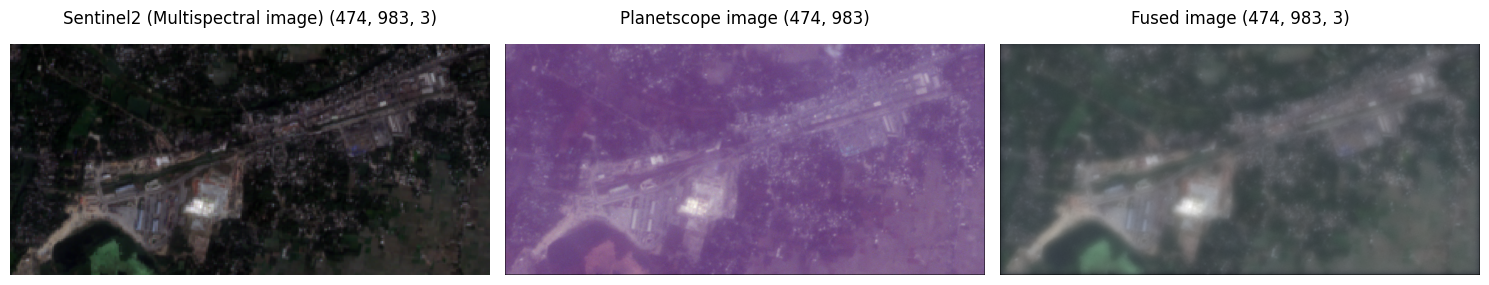

In [153]:
# Fused image normalization
vis_fus = np.copy(img_fus)
vis_fus[:,:,0] = ((vis_fus[:,:,0]-np.amin(vis_fus[:,:,0]))/(np.amax(vis_fus[:,:,0])-np.amin(vis_fus[:,:,0])))*255
vis_fus[:,:,1] = ((vis_fus[:,:,1]-np.amin(vis_fus[:,:,1]))/(np.amax(vis_fus[:,:,1])-np.amin(vis_fus[:,:,1])))*255
vis_fus[:,:,2] = ((vis_fus[:,:,2]-np.amin(vis_fus[:,:,2]))/(np.amax(vis_fus[:,:,2])-np.amin(vis_fus[:,:,2])))*255
vis_fus = vis_fus.astype(int)

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Increase the figure size
fig = plt.figure(figsize=(15, 5))  # Adjust the figure size to fit all images on one row

# Define the grid layout
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

# Add the multispectral image
ax0 = fig.add_subplot(spec[0,0])
ax0.imshow(xs)
ax0.set_title("Sentinel2 (Multispectral image) " + str(img_xs.shape), y=1.05)  # Adjust the title position
ax0.axis('off')

# Add the panchromatic image
ax1 = fig.add_subplot(spec[0,1])
ax1.imshow(planetscope_rgb)
ax1.set_title("Planetscope image " + str(img_pan.shape), y=1.05)  # Adjust the title position
ax1.axis('off')

# Add the fused image
ax2 = fig.add_subplot(spec[0,2])
ax2.imshow(vis_fus)
ax2.set_title("Fused image " + str(img_fus.shape), y=1.05)  # Adjust the title position
ax2.axis('off')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top spacing to fit titles

plt.show()

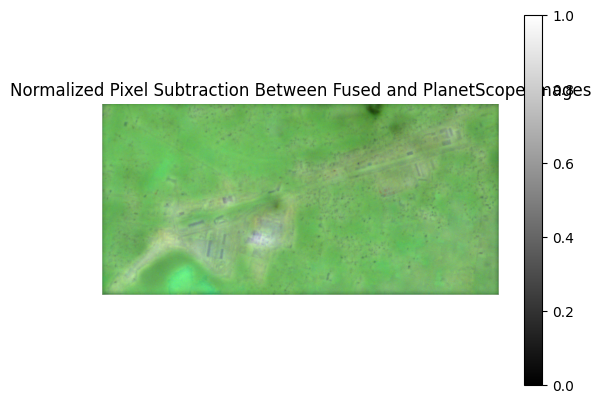

In [154]:
# Scale the difference image to the range [0, 1] for visualization
difference_image_scaled = difference_image - difference_image.min()
difference_image_scaled = difference_image_scaled / difference_image_scaled.max()

# Visualize the scaled difference
plt.imshow(difference_image_scaled, cmap='gray')
plt.title('Normalized Pixel Subtraction Between Fused and PlanetScope Images')
plt.axis('off')
plt.colorbar()
plt.show()

In [155]:
# Assuming 'difference_image' is a numpy array containing the pixel-wise differences
# between the fused image and the PlanetScope image.

# Mean Absolute Difference
mad = np.mean(np.abs(difference_image))

# Root Mean Square Error
rmse = np.sqrt(np.mean(np.square(difference_image)))

# Standard Deviation of Differences
std_dev = np.std(difference_image)

# Maximum Absolute Difference
max_diff = np.max(np.abs(difference_image))

mad, rmse, std_dev, max_diff

# Mean Absolute Difference (MAD) - 31.37: On average, each pixel in the difference image differs by about 31.37 intensity units from the corresponding pixel
# in the other image. This suggests a moderate level of difference between the two images on average.

# Root Mean Square Error (RMSE) - 37.40: The RMSE is slightly higher than the MAD, which is typical since RMSE gives extra weight to larger differences.
# This suggests the presence of some pixels with quite large differences between the two images.

# Standard Deviation of the Differences - 23.15: This value indicates variability in the differences between the two images.
# A standard deviation of 23.15 means that the differences vary by this amount from the average difference.

# Maximum Absolute Difference - 110: This is the largest difference observed between any pair of corresponding pixels in the two images.
# It might indicate outliers or points of significant discrepancy.

(31.367078592042215, 37.39926074543605, 23.154658543897913, 110)

In [156]:
def spectral_ERGAS(img_origND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_orig = np.empty(img_origND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    mean_img_orig = np.empty(n_band)
    mean_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_orig[:,:,i] = img_origND[:,:,i]*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_orig[i] = img_orig[:,:,i].mean()
        mean_img_fus[i] = img_fus[:,:,i].mean()

        # Diference between the multispectral image and the fused image
        dif_imgs[:,:,i] = img_orig[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_orig[i] - mean_img_fus[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_orig[i]**2)

    # Spectral ergas
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

def spatial_ERGAS(img_panND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_panc = np.empty(img_fusND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    img_pan_hist = np.empty(img_fusND.shape)
    mean_img_pan = np.empty(n_band)
    mean_img_multi = np.empty(n_band) # multi is the fused img
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_panc[:,:,i] = img_panND*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_pan[i] = img_panc[:,:,i].mean()
        mean_img_multi[i] = img_fus[:,:,i].mean()

        # Histogram of the panchromatic image
        delta_media = mean_img_multi[i] - mean_img_pan[i]
        img_pan_hist[:,:,i] = img_panc[:,:,i] + delta_media

        # Mean value of the panchromatic image histogram
        mean_img_pan[i] = img_pan_hist[:,:,i].mean()

        # Diference between the panchromatic image and the fused image
        dif_imgs[:,:,i] = img_pan_hist[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_pan[i] - mean_img_multi[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_pan[i]**2)

    # Spatial ERGAS
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

+----------------+---------------+
| Spectral ERGAS | Spatial ERGAS |
+================+===============+
| 2.518          | 3.789         |
+----------------+---------------+


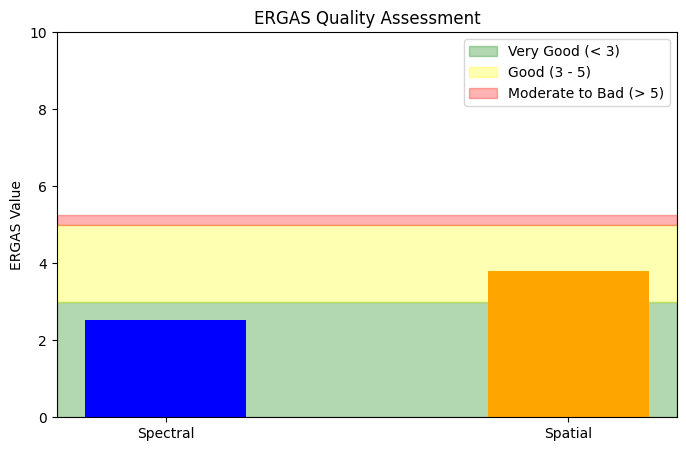

In [157]:
# ERGAS
ERGAS_X = spectral_ERGAS(img_xs, img_fus, 1/2, [1,1,1], 3)
ERGAS_S = spatial_ERGAS(img_pan, img_fus, 1/2, [1,1,1], 3)

# Display ERGAS on a table
tab = tt.Texttable()
headings = ['Spectral ERGAS','Spatial ERGAS']
tab.header(headings)
tab.add_row((ERGAS_X, ERGAS_S))
print(tab.draw())

import matplotlib.pyplot as plt
import numpy as np

# ERGAS values (replace these with your actual values)
ERGAS_X  # Example spectral ERGAS value
ERGAS_S   # Example spatial ERGAS value

# Define quality ranges
very_good_max = 3
good_max = 5

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 5))

# Define the ERGAS categories and values
categories = ['Spectral', 'Spatial']
values = [ERGAS_X, ERGAS_S]

# Define the bar positions
positions = np.arange(len(categories))

# Add color bands for quality ranges
ax.axhspan(0, very_good_max, color='green', alpha=0.3, label='Very Good (< 3)')
ax.axhspan(very_good_max, good_max, color='yellow', alpha=0.3, label='Good (3 - 5)')
ax.axhspan(good_max, ax.get_ylim()[1], color='red', alpha=0.3, label='Moderate to Bad (> 5)')

# Plot ERGAS values as bars
bar_width = 0.4
ax.bar(positions, values, color=['blue', 'orange'], width=bar_width, align='center')

# Set the x-axis labels and title
ax.set_xticks(positions)
ax.set_xticklabels(categories)
ax.set_ylabel('ERGAS Value')
ax.set_title('ERGAS Quality Assessment')

# Add legend
ax.legend(loc='upper right')

# Set y-axis limit
ax.set_ylim([0, 10])

# Show the plot
plt.show()

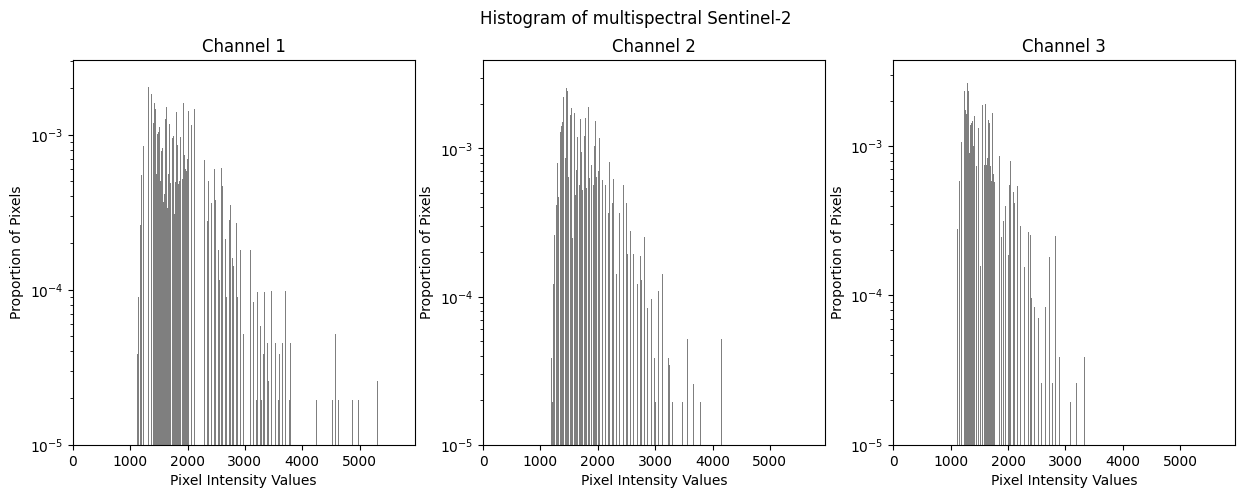

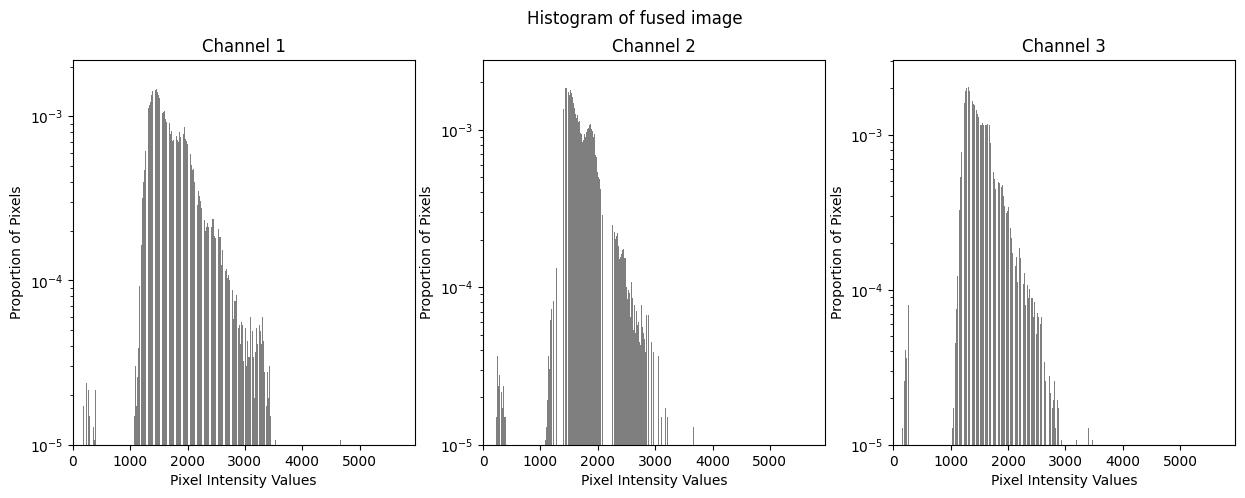

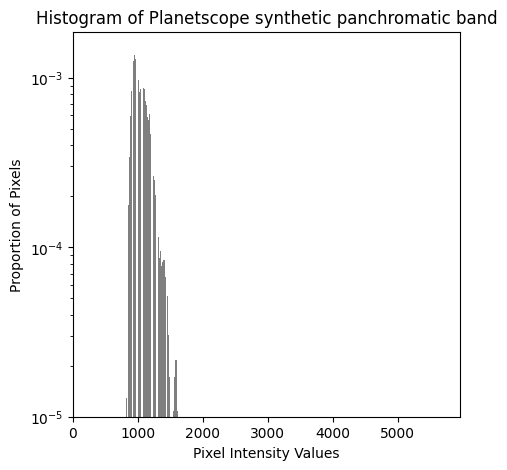

In [158]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms(image, title, min_pixel_value, max_pixel_value):
    """
    Plots the histogram for each channel of the image.
    Clips the range to the specified min and max pixel values and uses a logarithmic scale for y-axis.
    Normalizes the histograms to represent proportions.
    """
    # Calculate the number of bins for the histogram
    num_bins = max_pixel_value - min_pixel_value + 1

    if image.ndim == 3:  # Check if the image has multiple channels
        channels = image.shape[2]
        fig, axs = plt.subplots(1, channels, figsize=(15, 5))
        fig.suptitle(title)

        for i in range(channels):
            channel_data = image[..., i].ravel()
            # Remove zero values for the histogram
            channel_data_non_zero = channel_data[channel_data > min_pixel_value]
            # Normalize the histogram
            weights = np.ones_like(channel_data_non_zero) / float(len(channel_data_non_zero))
            axs[i].hist(channel_data_non_zero, bins=num_bins, weights=weights, color='k', alpha=0.5, log=True)
            axs[i].set_title(f'Channel {i+1}')
            axs[i].set_xlabel('Pixel Intensity Values')  # X-axis label
            axs[i].set_ylabel('Proportion of Pixels')  # Y-axis label
            axs[i].set_xlim([min_pixel_value, max_pixel_value])
            axs[i].set_ylim(bottom=1e-5)  # Set a bottom limit for logarithmic scale
    else:
        # Handle single-channel images
        data_non_zero = image[image > min_pixel_value].ravel()  # Remove zero values for the histogram
        # Normalize the histogram
        weights = np.ones_like(data_non_zero) / float(len(data_non_zero))
        plt.figure(figsize=(5, 5))
        plt.hist(data_non_zero, bins=num_bins, weights=weights, color='k', alpha=0.5, log=True)
        plt.xlabel('Pixel Intensity Values')  # X-axis label
        plt.ylabel('Proportion of Pixels')  # Y-axis label
        plt.title(title)
        plt.xlim([min_pixel_value, max_pixel_value])
        plt.ylim(bottom=1e-5)  # Set a bottom limit for logarithmic scale

    plt.show()

# Use the determined global min and max pixel values
global_min_pixel_value = 0
global_max_pixel_value = 5960

# Example usage:
# Assuming img_xs, img_fus, and img_pan are already loaded as NumPy arrays
plot_histograms(img_xs, 'Histogram of multispectral Sentinel-2', global_min_pixel_value, global_max_pixel_value)
plot_histograms(img_fus, 'Histogram of fused image', global_min_pixel_value, global_max_pixel_value)
plot_histograms(img_pan, 'Histogram of Planetscope synthetic panchromatic band', global_min_pixel_value, global_max_pixel_value)


In [159]:
# Weighted TWAT fusion with 5 cicles (Weight range -> [0,2])
#ERGAS - 24,24
img_fus = fusion_wtwa_multiband(img_xs, img_pan, 1.5, 5)
img_fus = img_fus.astype(np.uint16)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 0 of the multispectral image
---- 2.5780627727508545 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 1 of the multispectral image
---- 5.169434309005737 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 2 of the multispectral image
---- 7.96376371383667 seconds ------
---------------------------------------------------


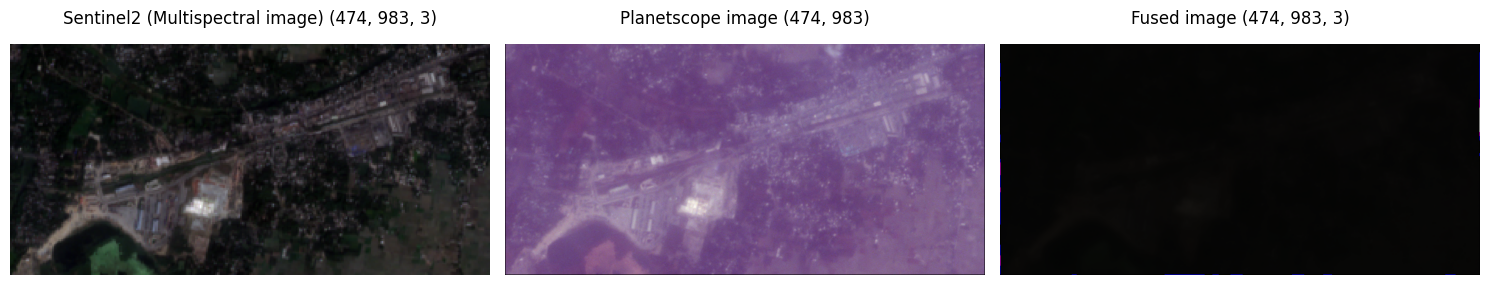

In [160]:
# Fused image normalization
vis_fus = np.copy(img_fus)
vis_fus[:,:,0] = ((vis_fus[:,:,0]-np.amin(vis_fus[:,:,0]))/(np.amax(vis_fus[:,:,0])-np.amin(vis_fus[:,:,0])))*255
vis_fus[:,:,1] = ((vis_fus[:,:,1]-np.amin(vis_fus[:,:,1]))/(np.amax(vis_fus[:,:,1])-np.amin(vis_fus[:,:,1])))*255
vis_fus[:,:,2] = ((vis_fus[:,:,2]-np.amin(vis_fus[:,:,2]))/(np.amax(vis_fus[:,:,2])-np.amin(vis_fus[:,:,2])))*255
vis_fus = vis_fus.astype(int)

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Increase the figure size
fig = plt.figure(figsize=(15, 5))  # Adjust the figure size to fit all images on one row

# Define the grid layout
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

# Add the multispectral image
ax0 = fig.add_subplot(spec[0,0])
ax0.imshow(xs)
ax0.set_title("Sentinel2 (Multispectral image) " + str(img_xs.shape), y=1.05)  # Adjust the title position
ax0.axis('off')

# Add the panchromatic image
ax1 = fig.add_subplot(spec[0,1])
ax1.imshow(planetscope_rgb)
ax1.set_title("Planetscope image " + str(img_pan.shape), y=1.05)  # Adjust the title position
ax1.axis('off')

# Add the fused image
ax2 = fig.add_subplot(spec[0,2])
ax2.imshow(vis_fus)
ax2.set_title("Fused image " + str(img_fus.shape), y=1.05)  # Adjust the title position
ax2.axis('off')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top spacing to fit titles

plt.show()

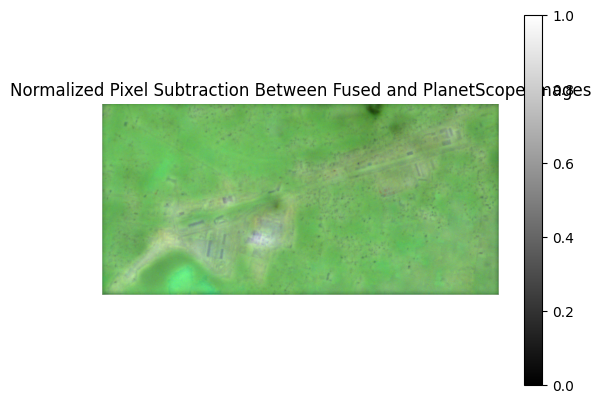

In [161]:
# Scale the difference image to the range [0, 1] for visualization
difference_image_scaled = difference_image - difference_image.min()
difference_image_scaled = difference_image_scaled / difference_image_scaled.max()

# Visualize the scaled difference
plt.imshow(difference_image_scaled, cmap='gray')
plt.title('Normalized Pixel Subtraction Between Fused and PlanetScope Images')
plt.axis('off')
plt.colorbar()
plt.show()

In [162]:
# Assuming 'difference_image' is a numpy array containing the pixel-wise differences
# between the fused image and the PlanetScope image.

# Mean Absolute Difference
mad = np.mean(np.abs(difference_image))

# Root Mean Square Error
rmse = np.sqrt(np.mean(np.square(difference_image)))

# Standard Deviation of Differences
std_dev = np.std(difference_image)

# Maximum Absolute Difference
max_diff = np.max(np.abs(difference_image))

mad, rmse, std_dev, max_diff

# Mean Absolute Difference (MAD) - 31.37: On average, each pixel in the difference image differs by about 31.37 intensity units from the corresponding pixel
# in the other image. This suggests a moderate level of difference between the two images on average.

# Root Mean Square Error (RMSE) - 37.40: The RMSE is slightly higher than the MAD, which is typical since RMSE gives extra weight to larger differences.
# This suggests the presence of some pixels with quite large differences between the two images.

# Standard Deviation of the Differences - 23.15: This value indicates variability in the differences between the two images.
# A standard deviation of 23.15 means that the differences vary by this amount from the average difference.

# Maximum Absolute Difference - 110: This is the largest difference observed between any pair of corresponding pixels in the two images.
# It might indicate outliers or points of significant discrepancy.

(31.367078592042215, 37.39926074543605, 23.154658543897913, 110)

In [163]:
def spectral_ERGAS(img_origND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_orig = np.empty(img_origND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    mean_img_orig = np.empty(n_band)
    mean_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_orig[:,:,i] = img_origND[:,:,i]*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_orig[i] = img_orig[:,:,i].mean()
        mean_img_fus[i] = img_fus[:,:,i].mean()

        # Diference between the multispectral image and the fused image
        dif_imgs[:,:,i] = img_orig[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_orig[i] - mean_img_fus[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_orig[i]**2)

    # Spectral ergas
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

def spatial_ERGAS(img_panND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_panc = np.empty(img_fusND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    img_pan_hist = np.empty(img_fusND.shape)
    mean_img_pan = np.empty(n_band)
    mean_img_multi = np.empty(n_band) # multi is the fused img
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_panc[:,:,i] = img_panND*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_pan[i] = img_panc[:,:,i].mean()
        mean_img_multi[i] = img_fus[:,:,i].mean()

        # Histogram of the panchromatic image
        delta_media = mean_img_multi[i] - mean_img_pan[i]
        img_pan_hist[:,:,i] = img_panc[:,:,i] + delta_media

        # Mean value of the panchromatic image histogram
        mean_img_pan[i] = img_pan_hist[:,:,i].mean()

        # Diference between the panchromatic image and the fused image
        dif_imgs[:,:,i] = img_pan_hist[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_pan[i] - mean_img_multi[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_pan[i]**2)

    # Spatial ERGAS
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

+----------------+---------------+
| Spectral ERGAS | Spatial ERGAS |
+================+===============+
| 24.915         | 24.206        |
+----------------+---------------+


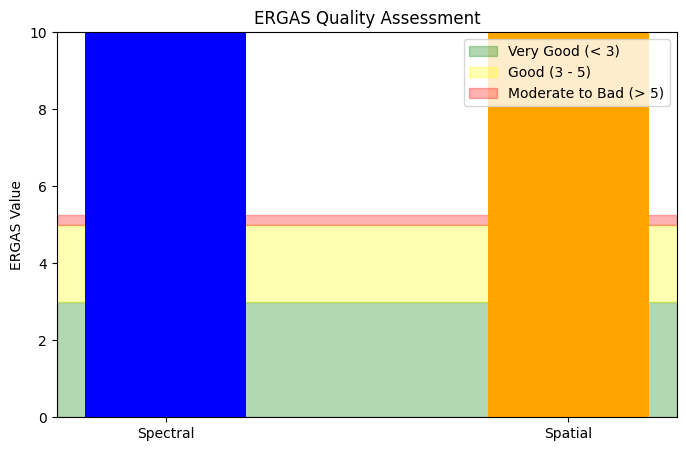

In [164]:
# ERGAS
ERGAS_X = spectral_ERGAS(img_xs, img_fus, 1/2, [1,1,1], 3)
ERGAS_S = spatial_ERGAS(img_pan, img_fus, 1/2, [1,1,1], 3)

# Display ERGAS on a table
tab = tt.Texttable()
headings = ['Spectral ERGAS','Spatial ERGAS']
tab.header(headings)
tab.add_row((ERGAS_X, ERGAS_S))
print(tab.draw())

import matplotlib.pyplot as plt
import numpy as np

# ERGAS values (replace these with your actual values)
ERGAS_X   # Example spectral ERGAS value
ERGAS_S   # Example spatial ERGAS value

# Define quality ranges
very_good_max = 3
good_max = 5

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 5))

# Define the ERGAS categories and values
categories = ['Spectral', 'Spatial']
values = [ERGAS_X, ERGAS_S]

# Define the bar positions
positions = np.arange(len(categories))

# Add color bands for quality ranges
ax.axhspan(0, very_good_max, color='green', alpha=0.3, label='Very Good (< 3)')
ax.axhspan(very_good_max, good_max, color='yellow', alpha=0.3, label='Good (3 - 5)')
ax.axhspan(good_max, ax.get_ylim()[1], color='red', alpha=0.3, label='Moderate to Bad (> 5)')

# Plot ERGAS values as bars
bar_width = 0.4
ax.bar(positions, values, color=['blue', 'orange'], width=bar_width, align='center')

# Set the x-axis labels and title
ax.set_xticks(positions)
ax.set_xticklabels(categories)
ax.set_ylabel('ERGAS Value')
ax.set_title('ERGAS Quality Assessment')

# Add legend
ax.legend(loc='upper right')

# Set y-axis limit
ax.set_ylim([0, 10])

# Show the plot
plt.show()

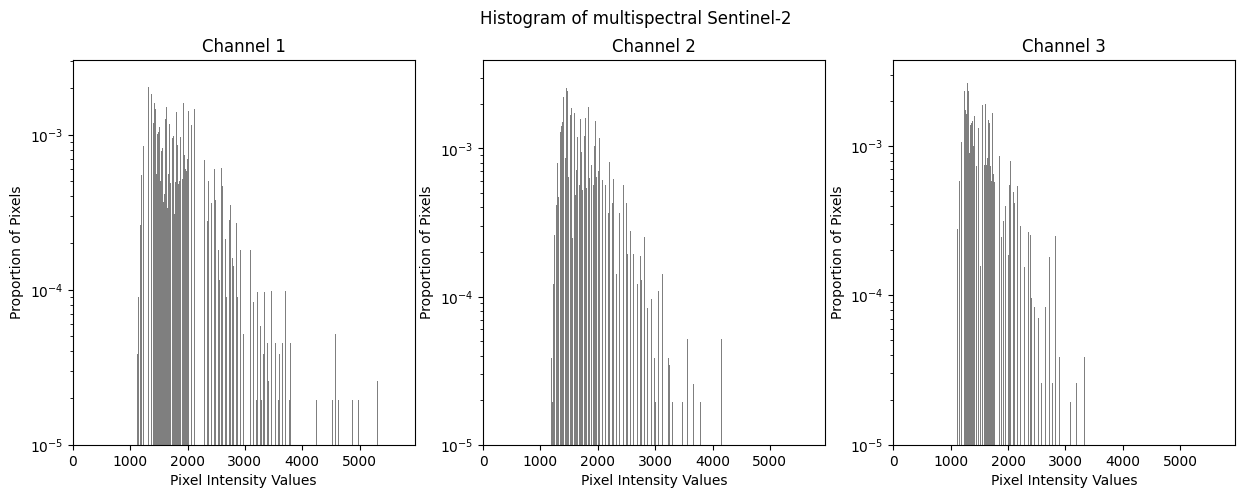

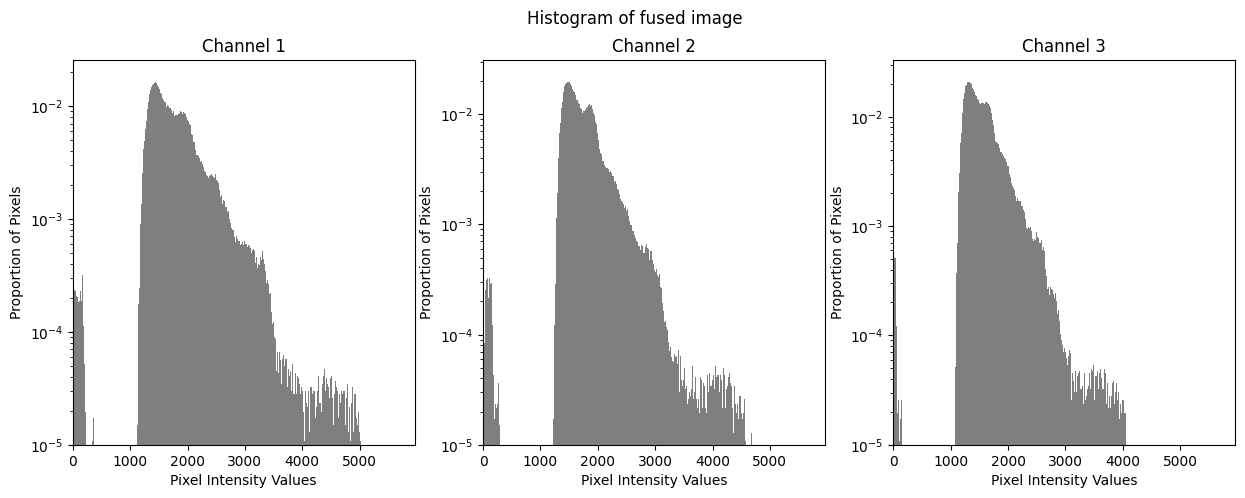

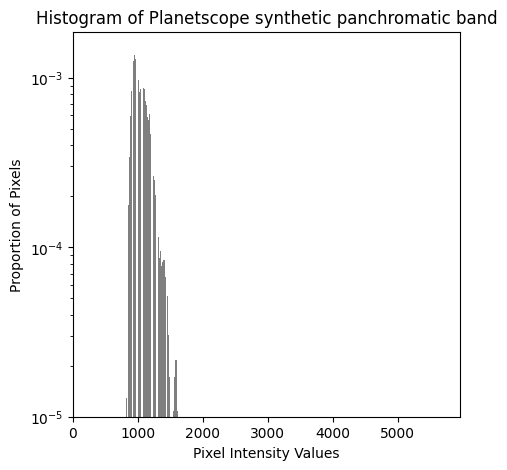

In [165]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms(image, title, min_pixel_value, max_pixel_value):
    """
    Plots the histogram for each channel of the image.
    Clips the range to the specified min and max pixel values and uses a logarithmic scale for y-axis.
    Normalizes the histograms to represent proportions.
    """
    # Calculate the number of bins for the histogram
    num_bins = max_pixel_value - min_pixel_value + 1

    if image.ndim == 3:  # Check if the image has multiple channels
        channels = image.shape[2]
        fig, axs = plt.subplots(1, channels, figsize=(15, 5))
        fig.suptitle(title)

        for i in range(channels):
            channel_data = image[..., i].ravel()
            # Remove zero values for the histogram
            channel_data_non_zero = channel_data[channel_data > min_pixel_value]
            # Normalize the histogram
            weights = np.ones_like(channel_data_non_zero) / float(len(channel_data_non_zero))
            axs[i].hist(channel_data_non_zero, bins=num_bins, weights=weights, color='k', alpha=0.5, log=True)
            axs[i].set_title(f'Channel {i+1}')
            axs[i].set_xlabel('Pixel Intensity Values')  # X-axis label
            axs[i].set_ylabel('Proportion of Pixels')  # Y-axis label
            axs[i].set_xlim([min_pixel_value, max_pixel_value])
            axs[i].set_ylim(bottom=1e-5)  # Set a bottom limit for logarithmic scale
    else:
        # Handle single-channel images
        data_non_zero = image[image > min_pixel_value].ravel()  # Remove zero values for the histogram
        # Normalize the histogram
        weights = np.ones_like(data_non_zero) / float(len(data_non_zero))
        plt.figure(figsize=(5, 5))
        plt.hist(data_non_zero, bins=num_bins, weights=weights, color='k', alpha=0.5, log=True)
        plt.xlabel('Pixel Intensity Values')  # X-axis label
        plt.ylabel('Proportion of Pixels')  # Y-axis label
        plt.title(title)
        plt.xlim([min_pixel_value, max_pixel_value])
        plt.ylim(bottom=1e-5)  # Set a bottom limit for logarithmic scale

    plt.show()

# Use the determined global min and max pixel values
global_min_pixel_value = 0
global_max_pixel_value = 5960

# Example usage:
# Assuming img_xs, img_fus, and img_pan are already loaded as NumPy arrays
plot_histograms(img_xs, 'Histogram of multispectral Sentinel-2', global_min_pixel_value, global_max_pixel_value)
plot_histograms(img_fus, 'Histogram of fused image', global_min_pixel_value, global_max_pixel_value)
plot_histograms(img_pan, 'Histogram of Planetscope synthetic panchromatic band', global_min_pixel_value, global_max_pixel_value)


In [166]:
# FractalxTWAT fusion with 5 cicles (the third parameter is the entropy radius)
img_fus = fusion_ftwa_multiband(img_xs, img_pan, 10, 5)
img_fus = img_fus.astype(np.uint16)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy
Fused band 0 of the multispectral image
---- 6.780811786651611 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy
Fused band 1 of the multispectral image
---- 15.13741135597229 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy
Fused band 2 of the multispectral image
---- 21.12817621231079 seconds ------
---------------------------------------------------


In [167]:
# img_fus[:,:,0] = ((img_fus[:,:,0]-np.amin(img_fus[:,:,0]))/(np.amax(img_fus[:,:,0])-np.amin(img_fus[:,:,0])))*np.amax(img_xs[:,:,0]) + ((np.amax(img_fus[:,:,0]) - img_fus[:,:,0])/(np.amax(img_fus[:,:,0])-np.amin(img_fus[:,:,0])))*np.amin(img_xs[:,:,0])
# img_fus[:,:,1] = ((img_fus[:,:,1]-np.amin(img_fus[:,:,1]))/(np.amax(img_fus[:,:,1])-np.amin(img_fus[:,:,1])))*np.amax(img_xs[:,:,1]) + ((np.amax(img_fus[:,:,1]) - img_fus[:,:,1])/(np.amax(img_fus[:,:,1])-np.amin(img_fus[:,:,1])))*np.amin(img_xs[:,:,1])
# img_fus[:,:,2] = ((img_fus[:,:,2]-np.amin(img_fus[:,:,2]))/(np.amax(img_fus[:,:,2])-np.amin(img_fus[:,:,2])))*np.amax(img_xs[:,:,2]) + ((np.amax(img_fus[:,:,2]) - img_fus[:,:,2])/(np.amax(img_fus[:,:,2])-np.amin(img_fus[:,:,2])))*np.amin(img_xs[:,:,2])
# print('Completed normalization to the multispectral image values')

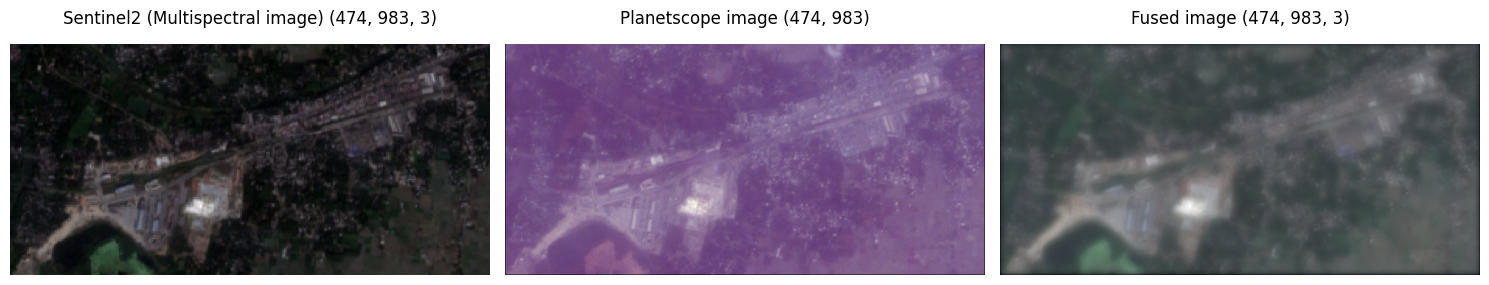

In [168]:
# Fused image normalization
vis_fus = np.copy(img_fus)
vis_fus[:,:,0] = ((vis_fus[:,:,0]-np.amin(vis_fus[:,:,0]))/(np.amax(vis_fus[:,:,0])-np.amin(vis_fus[:,:,0])))*255
vis_fus[:,:,1] = ((vis_fus[:,:,1]-np.amin(vis_fus[:,:,1]))/(np.amax(vis_fus[:,:,1])-np.amin(vis_fus[:,:,1])))*255
vis_fus[:,:,2] = ((vis_fus[:,:,2]-np.amin(vis_fus[:,:,2]))/(np.amax(vis_fus[:,:,2])-np.amin(vis_fus[:,:,2])))*255
vis_fus = vis_fus.astype(int)

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Increase the figure size
fig = plt.figure(figsize=(15, 5))  # Adjust the figure size to fit all images on one row

# Define the grid layout
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

# Add the multispectral image
ax0 = fig.add_subplot(spec[0,0])
ax0.imshow(xs)
ax0.set_title("Sentinel2 (Multispectral image) " + str(img_xs.shape), y=1.05)  # Adjust the title position
ax0.axis('off')

# Add the panchromatic image
ax1 = fig.add_subplot(spec[0,1])
ax1.imshow(planetscope_rgb)
ax1.set_title("Planetscope image " + str(img_pan.shape), y=1.05)  # Adjust the title position
ax1.axis('off')

# Add the fused image
ax2 = fig.add_subplot(spec[0,2])
ax2.imshow(vis_fus)
ax2.set_title("Fused image " + str(img_fus.shape), y=1.05)  # Adjust the title position
ax2.axis('off')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top spacing to fit titles

plt.show()

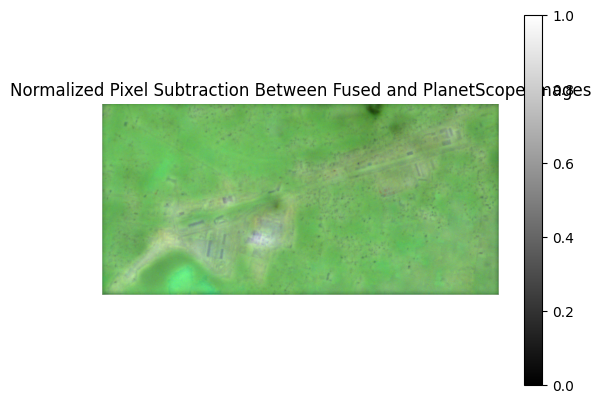

In [169]:
# Scale the difference image to the range [0, 1] for visualization
difference_image_scaled = difference_image - difference_image.min()
difference_image_scaled = difference_image_scaled / difference_image_scaled.max()

# Visualize the scaled difference
plt.imshow(difference_image_scaled, cmap='gray')
plt.title('Normalized Pixel Subtraction Between Fused and PlanetScope Images')
plt.axis('off')
plt.colorbar()
plt.show()



In [170]:
# Assuming 'difference_image' is a numpy array containing the pixel-wise differences
# between the fused image and the PlanetScope image.

# Mean Absolute Difference
mad = np.mean(np.abs(difference_image))

# Root Mean Square Error
rmse = np.sqrt(np.mean(np.square(difference_image)))

# Standard Deviation of Differences
std_dev = np.std(difference_image)

# Maximum Absolute Difference
max_diff = np.max(np.abs(difference_image))

mad, rmse, std_dev, max_diff

# Mean Absolute Difference (MAD) - 31.37: On average, each pixel in the difference image differs by about 31.37 intensity units from the corresponding pixel
# in the other image. This suggests a moderate level of difference between the two images on average.

# Root Mean Square Error (RMSE) - 37.40: The RMSE is slightly higher than the MAD, which is typical since RMSE gives extra weight to larger differences.
# This suggests the presence of some pixels with quite large differences between the two images.

# Standard Deviation of the Differences - 23.15: This value indicates variability in the differences between the two images.
# A standard deviation of 23.15 means that the differences vary by this amount from the average difference.

# Maximum Absolute Difference - 110: This is the largest difference observed between any pair of corresponding pixels in the two images.
# It might indicate outliers or points of significant discrepancy.

(31.367078592042215, 37.39926074543605, 23.154658543897913, 110)

In [171]:
def spectral_ERGAS(img_origND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_orig = np.empty(img_origND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    mean_img_orig = np.empty(n_band)
    mean_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_orig[:,:,i] = img_origND[:,:,i]*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_orig[i] = img_orig[:,:,i].mean()
        mean_img_fus[i] = img_fus[:,:,i].mean()

        # Diference between the multispectral image and the fused image
        dif_imgs[:,:,i] = img_orig[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_orig[i] - mean_img_fus[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_orig[i]**2)

    # Spectral ergas
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

def spatial_ERGAS(img_panND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_panc = np.empty(img_fusND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    img_pan_hist = np.empty(img_fusND.shape)
    mean_img_pan = np.empty(n_band)
    mean_img_multi = np.empty(n_band) # multi is the fused img
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_panc[:,:,i] = img_panND*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_pan[i] = img_panc[:,:,i].mean()
        mean_img_multi[i] = img_fus[:,:,i].mean()

        # Histogram of the panchromatic image
        delta_media = mean_img_multi[i] - mean_img_pan[i]
        img_pan_hist[:,:,i] = img_panc[:,:,i] + delta_media

        # Mean value of the panchromatic image histogram
        mean_img_pan[i] = img_pan_hist[:,:,i].mean()

        # Diference between the panchromatic image and the fused image
        dif_imgs[:,:,i] = img_pan_hist[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_pan[i] - mean_img_multi[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_pan[i]**2)

    # Spatial ERGAS
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

+----------------+---------------+
| Spectral ERGAS | Spatial ERGAS |
+================+===============+
| 2.586          | 3.859         |
+----------------+---------------+


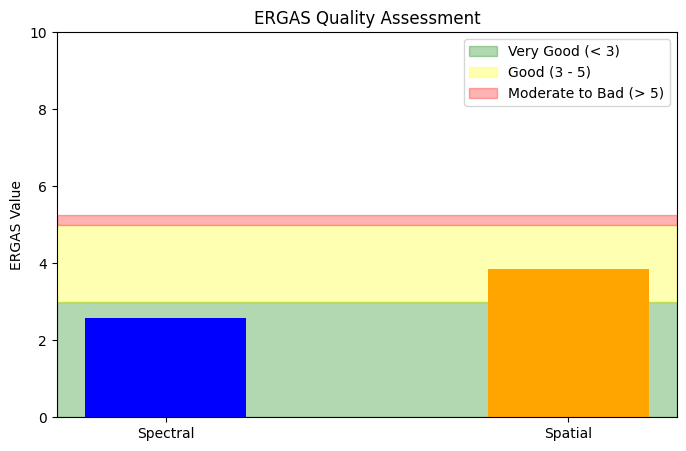

In [172]:
# ERGAS
ERGAS_X = spectral_ERGAS(img_xs, img_fus, 1/2, [1,1,1], 3)
ERGAS_S = spatial_ERGAS(img_pan, img_fus, 1/2, [1,1,1], 3)

# Display ERGAS on a table
tab = tt.Texttable()
headings = ['Spectral ERGAS','Spatial ERGAS']
tab.header(headings)
tab.add_row((ERGAS_X, ERGAS_S))
print(tab.draw())

import matplotlib.pyplot as plt
import numpy as np

# ERGAS values (replace these with your actual values)
ERGAS_X    # Example spectral ERGAS value
ERGAS_S   # Example spatial ERGAS value

# Define quality ranges
very_good_max = 3
good_max = 5

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 5))

# Define the ERGAS categories and values
categories = ['Spectral', 'Spatial']
values = [ERGAS_X, ERGAS_S]

# Define the bar positions
positions = np.arange(len(categories))

# Add color bands for quality ranges
ax.axhspan(0, very_good_max, color='green', alpha=0.3, label='Very Good (< 3)')
ax.axhspan(very_good_max, good_max, color='yellow', alpha=0.3, label='Good (3 - 5)')
ax.axhspan(good_max, ax.get_ylim()[1], color='red', alpha=0.3, label='Moderate to Bad (> 5)')

# Plot ERGAS values as bars
bar_width = 0.4
ax.bar(positions, values, color=['blue', 'orange'], width=bar_width, align='center')

# Set the x-axis labels and title
ax.set_xticks(positions)
ax.set_xticklabels(categories)
ax.set_ylabel('ERGAS Value')
ax.set_title('ERGAS Quality Assessment')

# Add legend
ax.legend(loc='upper right')

# Set y-axis limit
ax.set_ylim([0, 10])

# Show the plot
plt.show()

In [173]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_histograms(image, title):
#     """
#     Plots the histogram for each channel of the image
#     """
#     if image.ndim == 3:  # Check if the image has multiple channels
#         channels = image.shape[2]
#         fig, axs = plt.subplots(1, channels, figsize=(15, 5))
#         fig.suptitle(title)

#         for i in range(channels):
#             axs[i].hist(image[..., i].ravel(), bins=256, color='k', alpha=0.5)
#             axs[i].set_title(f'Channel {i+1}')
#             axs[i].set_xlim([0, 256])
#     else:
#         # Handle single-channel images
#         plt.figure(figsize=(5, 5))
#         plt.hist(image.ravel(), bins=256, color='k', alpha=0.5)
#         plt.title(title)
#         plt.xlim([0, 256])

#     plt.show()

# # Assuming img_xs, img_fus, and img_pan are already loaded as NumPy arrays
# plot_histograms(img_xs, 'Histogram of Multispectral image')
# plot_histograms(img_fus, 'Histogram of fused image')
# plot_histograms(img_pan, 'Histogram of planetscope image')


In [174]:
# def plot_histograms(image, title, scale_to_8bit=False):
#     """
#     Plots the histogram for each channel of the image.
#     If scale_to_8bit is True, it will rescale the image assuming the current max value should map to 255.
#     """
#     if scale_to_8bit:
#         image = (image / image.max()) * 255
#         image = image.astype(np.uint8)

#     if image.ndim == 3:  # Check if the image has multiple channels
#         channels = image.shape[2]
#         fig, axs = plt.subplots(1, channels, figsize=(15, 5))
#         fig.suptitle(title)

#         for i in range(channels):
#             data = image[..., i].ravel()
#             axs[i].hist(data, bins=256, color='k', alpha=0.5)
#             axs[i].set_title(f'Channel {i+1}')
#             axs[i].set_xlim([np.min(data), np.max(data)])
#     else:
#         # Handle single-channel images
#         data = image.ravel()
#         plt.figure(figsize=(5, 5))
#         plt.hist(data, bins=256, color='k', alpha=0.5)
#         plt.title(title)
#         plt.xlim([np.min(data), np.max(data)])

#     plt.show()

# # Then call the function with the scale_to_8bit parameter as needed:
# plot_histograms(img_xs, 'Histogram of mulitpectral sentinal2', scale_to_8bit=True)
# plot_histograms(img_fus, 'Histogram of fused image', scale_to_8bit=True)
# plot_histograms(img_pan, 'Histogram of planetscope synthetic panchromatic band', scale_to_8bit=True)


In [175]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_histograms(image, title):
#     """
#     Plots the histogram for each channel of the image.
#     Clips the range to non-zero data and uses a logarithmic scale for y-axis.
#     """
#     if image.ndim == 3:  # Check if the image has multiple channels
#         channels = image.shape[2]
#         fig, axs = plt.subplots(1, channels, figsize=(15, 5))
#         fig.suptitle(title)

#         for i in range(channels):
#             channel_data = image[..., i].ravel()
#             # Remove zero values for the histogram
#             channel_data_non_zero = channel_data[channel_data > 0]
#             axs[i].hist(channel_data_non_zero, bins=256, color='k', alpha=0.5, log=True)
#             axs[i].set_title(f'Channel {i+1}')
#             axs[i].set_xlim([np.min(channel_data_non_zero), np.max(channel_data_non_zero)])
#     else:
#         # Handle single-channel images
#         data_non_zero = image[image > 0].ravel()  # Remove zero values for the histogram
#         plt.figure(figsize=(5, 5))
#         plt.hist(data_non_zero, bins=256, color='k', alpha=0.5, log=True)
#         plt.title(title)
#         plt.xlim([np.min(data_non_zero), np.max(data_non_zero)])

#     plt.show()

# # Assuming img_xs, img_fus, and img_pan are already loaded as NumPy arrays
# plot_histograms(img_xs, 'Histogram of mulitpectral sentinal2')
# plot_histograms(img_fus, 'Histogram of fused image')
# plot_histograms(img_pan, 'Histogram of planetscope synthetic panchromatic band')


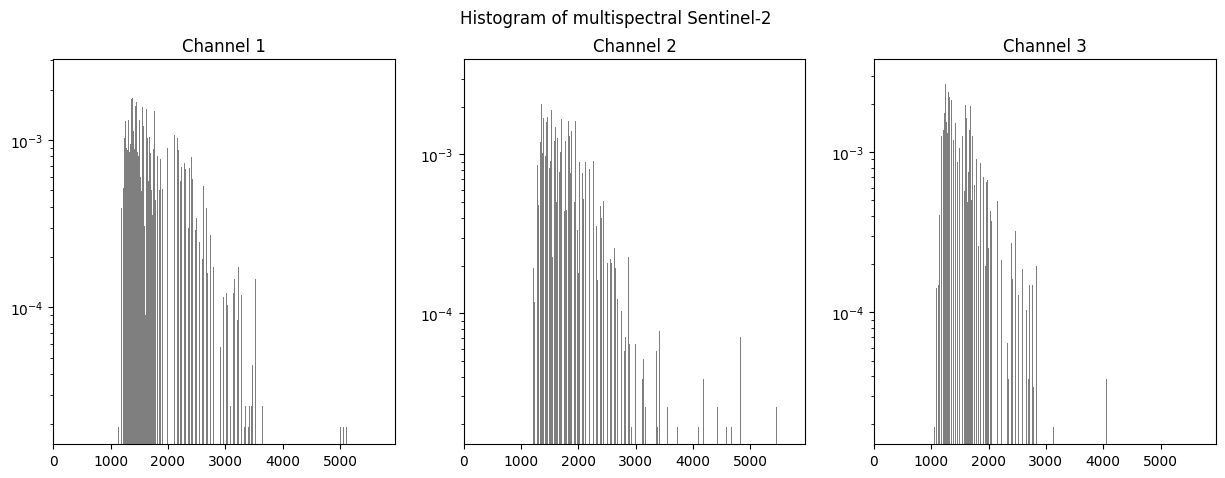

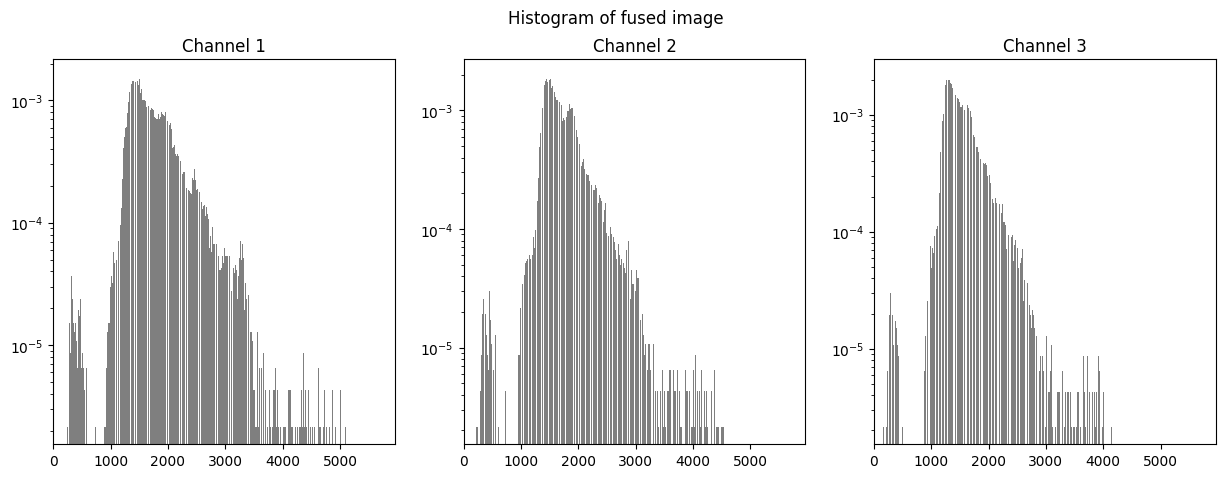

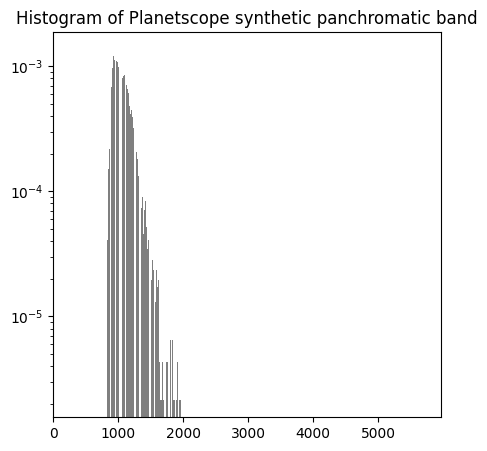

In [176]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms(image, title, min_pixel_value, max_pixel_value):
    """
    Plots the histogram for each channel of the image.
    Clips the range to the specified min and max pixel values and uses a logarithmic scale for y-axis.
    Normalizes the histograms to represent proportions.
    """
    # Calculate the number of bins for the histogram
    num_bins = max_pixel_value - min_pixel_value + 1

    if image.ndim == 3:  # Check if the image has multiple channels
        channels = image.shape[2]
        fig, axs = plt.subplots(1, channels, figsize=(15, 5))
        fig.suptitle(title)

        for i in range(channels):
            channel_data = image[..., i].ravel()
            # Remove zero values for the histogram
            channel_data_non_zero = channel_data[channel_data > min_pixel_value]
            # Normalize the histogram
            weights = np.ones_like(channel_data_non_zero) / float(len(channel_data_non_zero))
            axs[i].hist(channel_data_non_zero, bins=num_bins, weights=weights, color='k', alpha=0.5, log=True)
            axs[i].set_title(f'Channel {i+1}')
            axs[i].set_xlim([min_pixel_value, max_pixel_value])
    else:
        # Handle single-channel images
        data_non_zero = image[image > min_pixel_value].ravel()  # Remove zero values for the histogram
        # Normalize the histogram
        weights = np.ones_like(data_non_zero) / float(len(data_non_zero))
        plt.figure(figsize=(5, 5))
        plt.hist(data_non_zero, bins=num_bins, weights=weights, color='k', alpha=0.5, log=True)
        plt.title(title)
        plt.xlim([min_pixel_value, max_pixel_value])

    plt.show()

# Use the determined global min and max pixel values
global_min_pixel_value = 0
global_max_pixel_value = 5960

# Example usage:
# Assuming img_xs, img_fus, and img_pan are already loaded as NumPy arrays
plot_histograms(img_xs, 'Histogram of multispectral Sentinel-2', global_min_pixel_value, global_max_pixel_value)
plot_histograms(img_fus, 'Histogram of fused image', global_min_pixel_value, global_max_pixel_value)
plot_histograms(img_pan, 'Histogram of Planetscope synthetic panchromatic band', global_min_pixel_value, global_max_pixel_value)


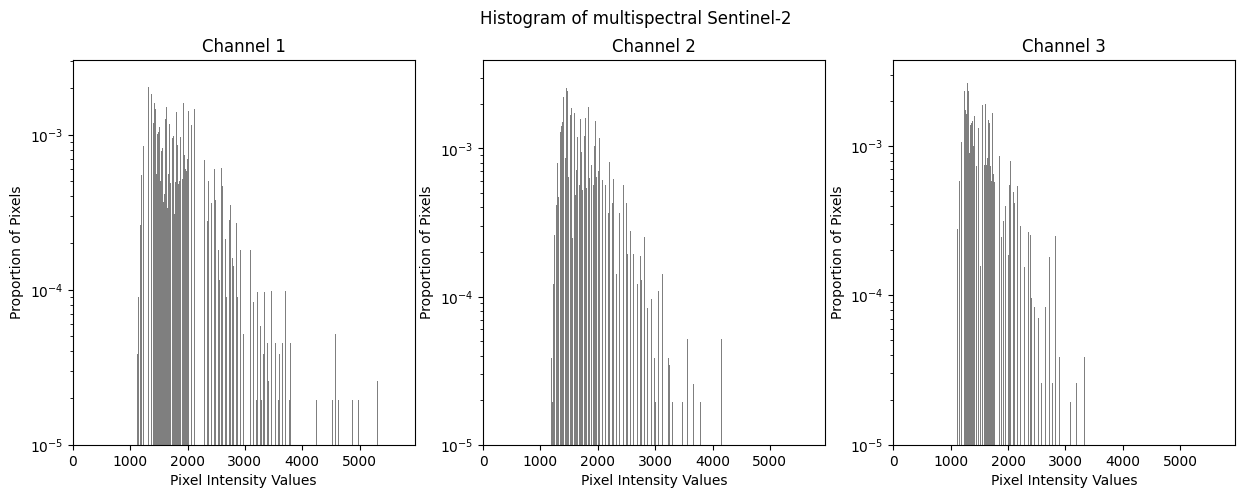

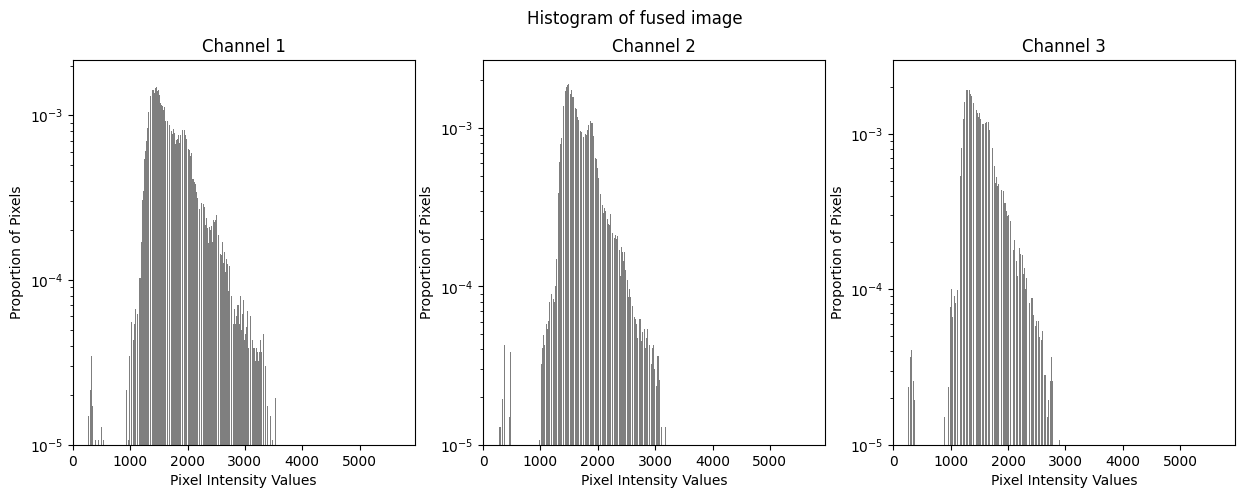

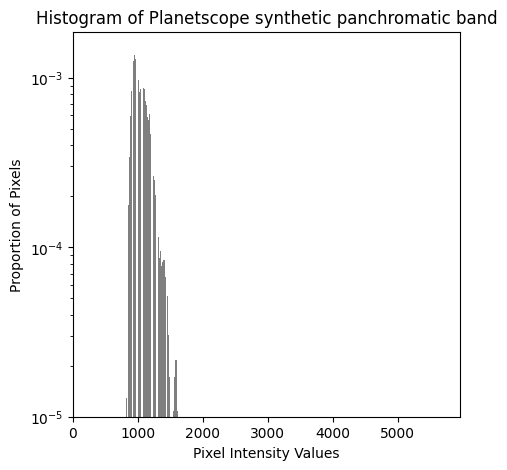

In [177]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms(image, title, min_pixel_value, max_pixel_value):
    """
    Plots the histogram for each channel of the image.
    Clips the range to the specified min and max pixel values and uses a logarithmic scale for y-axis.
    Normalizes the histograms to represent proportions.
    """
    # Calculate the number of bins for the histogram
    num_bins = max_pixel_value - min_pixel_value + 1

    if image.ndim == 3:  # Check if the image has multiple channels
        channels = image.shape[2]
        fig, axs = plt.subplots(1, channels, figsize=(15, 5))
        fig.suptitle(title)

        for i in range(channels):
            channel_data = image[..., i].ravel()
            # Remove zero values for the histogram
            channel_data_non_zero = channel_data[channel_data > min_pixel_value]
            # Normalize the histogram
            weights = np.ones_like(channel_data_non_zero) / float(len(channel_data_non_zero))
            axs[i].hist(channel_data_non_zero, bins=num_bins, weights=weights, color='k', alpha=0.5, log=True)
            axs[i].set_title(f'Channel {i+1}')
            axs[i].set_xlabel('Pixel Intensity Values')  # X-axis label
            axs[i].set_ylabel('Proportion of Pixels')  # Y-axis label
            axs[i].set_xlim([min_pixel_value, max_pixel_value])
            axs[i].set_ylim(bottom=1e-5)  # Set a bottom limit for logarithmic scale
    else:
        # Handle single-channel images
        data_non_zero = image[image > min_pixel_value].ravel()  # Remove zero values for the histogram
        # Normalize the histogram
        weights = np.ones_like(data_non_zero) / float(len(data_non_zero))
        plt.figure(figsize=(5, 5))
        plt.hist(data_non_zero, bins=num_bins, weights=weights, color='k', alpha=0.5, log=True)
        plt.xlabel('Pixel Intensity Values')  # X-axis label
        plt.ylabel('Proportion of Pixels')  # Y-axis label
        plt.title(title)
        plt.xlim([min_pixel_value, max_pixel_value])
        plt.ylim(bottom=1e-5)  # Set a bottom limit for logarithmic scale

    plt.show()

# Use the determined global min and max pixel values
global_min_pixel_value = 0
global_max_pixel_value = 5960

# Example usage:
# Assuming img_xs, img_fus, and img_pan are already loaded as NumPy arrays
plot_histograms(img_xs, 'Histogram of multispectral Sentinel-2', global_min_pixel_value, global_max_pixel_value)
plot_histograms(img_fus, 'Histogram of fused image', global_min_pixel_value, global_max_pixel_value)
plot_histograms(img_pan, 'Histogram of Planetscope synthetic panchromatic band', global_min_pixel_value, global_max_pixel_value)
